In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import proplot as pplt
import xarray
#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

d:\Miniconda3\envs\guteEnv\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#############################################################
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
Xanthos_grid_areas = np.array(pd.read_csv(dir_in + '/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')

n_basin = GRDC_xanthosCoordIndx.shape[0]
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = [basinName['Basin_Name'][basins94[ii] - 1] for ii in range(n_basin)]
reservoirs_halfDegree = xarray.open_dataset(dir_in + '/Xanthos_reservoirs_halfDegree_global.nc')

## Release

In [3]:

ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = dir_in + '/Simulated/SimulatedFinal-HP/reservoirRelease/'
file_dir_fc = dir_in + '/Simulated/SimulatedFinal-FC/reservoirRelease/'
dir_usgrid = dir_in + '/UScells/contributing_grids_all'

for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    ppose_HP = ppose_basin[ppose_basin==3]
    capac_HP = capac_basin[capac_basin==3]
    Lon_HP = Lon_basin[ppose_basin==3]
    Lat_HP = Lat_basin[ppose_basin==3]

    if jj==0:
        mm = len(ppose_HP)
    else:
        mm = mm + len(ppose_HP)


In [4]:

ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp = dir_in + '/Simulated/SimulatedFinal-HP/reservoirRelease/'
file_dir_fc = dir_in + '/Simulated/SimulatedFinal-FC/reservoirRelease/'
dir_usgrid = dir_in + '/UScells/contributing_grids_all'

for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[ppose_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'ReservoirsRelease_' + str(basin_num) + '.npy')   

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]
        # with flood control
        rsim_fc= data_basin_fc[mm,:]
        #plt.show()
        nrmse_hpfc[ii] = spotpy.objectivefunctions.rrmse( rsim_hp[0:240], rsim_fc[0:240])#/np.mean(rsim_hp[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared( rsim_hp[0:240], rsim_fc[0:240])

    nrmse_hpfc_df_release = pd.DataFrame()
    nrmse_hpfc_df_release['Lon'] = Lon_HP
    nrmse_hpfc_df_release['Lat'] = Lat_HP

    #kge_hpfc[kge_hpfc  < -1] = -1 #for colorbar purpose only
    nrmse_hpfc_df_release['NRMSE'] = nrmse_hpfc
    nrmse_hpfc_df_release['R2'] = r2_hpfc
    nrmse_hpfc_df_release['basin_num'] = basin_num
    if jj==0:
        nrmse_hpfc_all_release = nrmse_hpfc_df_release
    else:
        nrmse_hpfc_all_release = pd.concat([nrmse_hpfc_all_release, nrmse_hpfc_df_release],0)


    if basin_num==48:
        yenisey_release_df = nrmse_hpfc_df_release
        yenisey_release_df['CAP']=capac_HP

nrmse_hpfc_all_release = nrmse_hpfc_all_release.reset_index(drop=True)

#### Storage 

In [5]:
# directory for reservoir release data
file_dir_hp = dir_in + '/Simulated/SimulatedFinal-HP/reservoir/'
file_dir_fc = dir_in + '/Simulated/SimulatedFinal-FC/reservoir/'
cc=0
for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[ppose_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated
    data_basin_hp = np.load(file_dir_hp + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc = np.load(file_dir_fc + 'SimReservoirs_' + str(basin_num) + '.npy')   
    if np.sum(data_basin_fc)==0:
        cc+=1

    # compute KGE between the two
    nrmse_hpfc = np.zeros([indx_basin.shape[0],])
    r2_hpfc  = np.zeros([indx_basin.shape[0],])
    for ii in range(indx_basin.shape[0]):
        mm = indx_basin[ii]
        # with hydropower
        rsim_hp= data_basin_hp[mm,:]*1e-6
        # with flood control
        rsim_fc= data_basin_fc[mm,:]*1e-6
        #plt.show()
        nrmse_hpfc[ii] = spotpy.objectivefunctions.rrmse(rsim_hp[0:240], rsim_fc[0:240])#/np.mean(rsim_hp[0:240])
        r2_hpfc[ii] = spotpy.objectivefunctions.rsquared(rsim_hp[0:240], rsim_fc[0:240])

    nrmse_hpfc_df_storage = pd.DataFrame()
    nrmse_hpfc_df_storage['Lon'] = Lon_HP
    nrmse_hpfc_df_storage['Lat'] = Lat_HP

    #nrmse_hpfc[kge_hpfc  <-1] = -1 #for colorbar purpose only
    nrmse_hpfc_df_storage['NRMSE'] = nrmse_hpfc
    nrmse_hpfc_df_storage['R2'] = r2_hpfc
    if jj==0:
        nrmse_hpfc_all_storage = nrmse_hpfc_df_storage
    else:
        nrmse_hpfc_all_storage = pd.concat([nrmse_hpfc_all_storage, nrmse_hpfc_df_storage],0)
    if basin_num==48:
        yenisey_storage_df = nrmse_hpfc_df_storage
        yenisey_storage_df['CAP']=capac_HP

nrmse_hpfc_all_storage = nrmse_hpfc_all_storage.reset_index(drop=True)

In [6]:
yenisey_release_df['HP'] = ['HP-1', 'HP-2', 'HP-3', 'HP-4']
#yenisey_release_df

In [7]:
yenisey_storage_df['HP'] = ['HP-1', 'HP-2', 'HP-3', 'HP-4']
#yenisey_storage_df

In [8]:
np.where(basins94==15)[0]

array([11], dtype=int64)

In [9]:
basinName_94[11]

'Hudson Bay Coast'

In [10]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 14, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
import seaborn as sns

idx = np.where(nrmse_hpfc_all_storage['NRMSE']>nrmse_hpfc_all_release['NRMSE'].max())
nrmse_hpfc_all_storage['NRMSE'].loc[idx] = np.nan


data_r2 = pd.DataFrame()
data_r2['Release'] = nrmse_hpfc_all_release['R2']
data_r2['Storage'] = nrmse_hpfc_all_storage['R2']

data_rmse = pd.DataFrame()
data_rmse['Release'] = nrmse_hpfc_all_release['NRMSE']
data_rmse['Storage'] = nrmse_hpfc_all_storage['NRMSE']

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 300, "facecolor": "w"}

In [11]:
x = data_r2['Release'].values
x, y = sorted(x), np.arange(len(x)) / len(x)

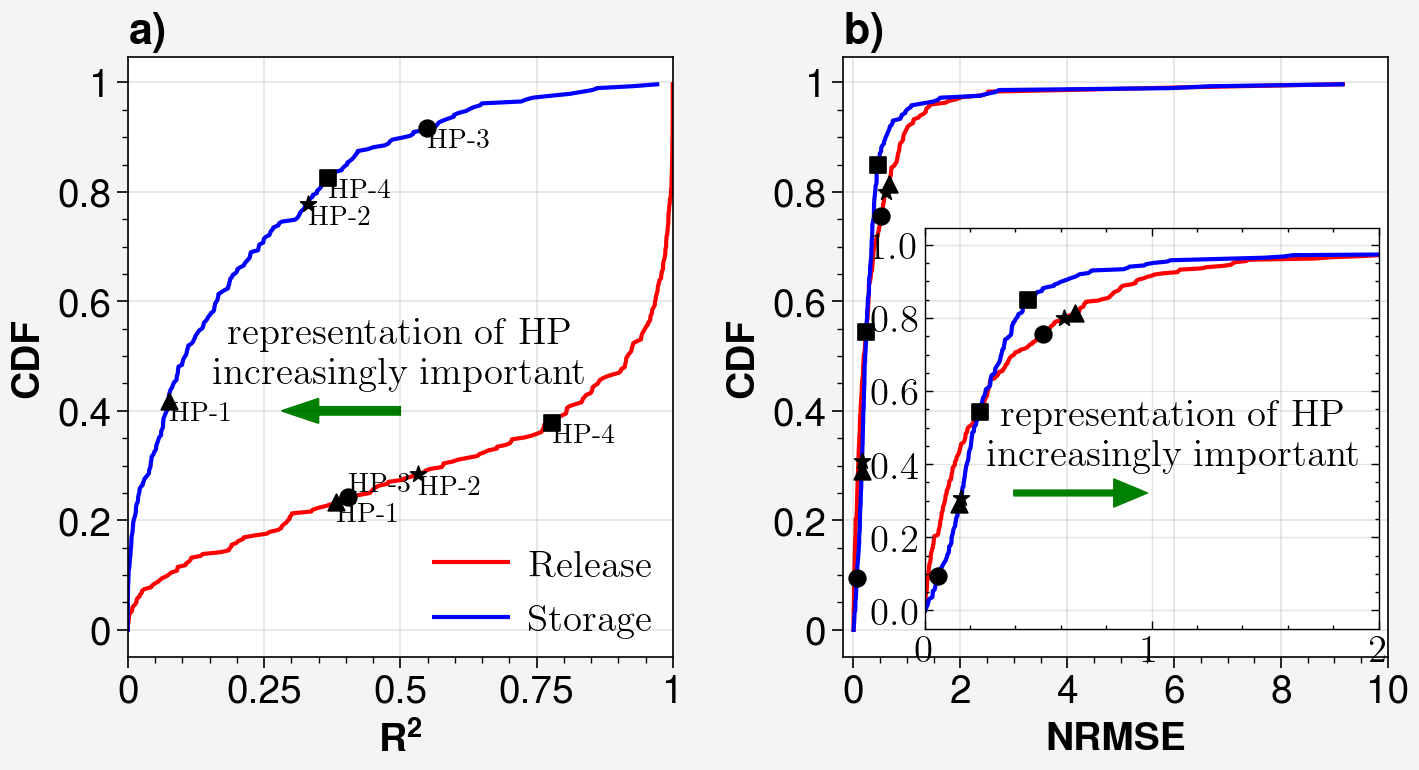

In [12]:
fig, axs =  pplt.subplots(ncols=2, nrows=1,refheight=3, refwidth=3.75, share=0, journal='nat2')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    #fig, axs = pplt.subplots(ncols=2, nrows=1,refaspect=1, refheight=2.70, refwidth=4.50, share=0)
    # R2
    #sns.kdeplot(data = data_r2['Release'], cumulative = True, label = "Release", color="red", ax=axs[0], legend=False)
    #sns.kdeplot(data = data_r2['Storage'], cumulative = True, label = "Storage", color="blue", ax=axs[0], legend=False)
    # release
    x = data_r2['Release'].values
    x, y = sorted(x), np.arange(len(x)) / len(x)
    axs[0].plot(x, y, color="r", linestyle = '-',  lw=1.5, label = 'Release',zorder=1)    

    axs[0].scatter(yenisey_release_df['R2'][0], y[np.where(x==yenisey_release_df['R2'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-1', xy=(0.5, 0.4),xytext=(yenisey_release_df['R2'][0], y[np.where(x==yenisey_release_df['R2'][0])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    axs[0].scatter(yenisey_release_df['R2'][1], y[np.where(x==yenisey_release_df['R2'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-2', xy=(0.5, 0.4),xytext=(yenisey_release_df['R2'][1], y[np.where(x==yenisey_release_df['R2'][1])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    axs[0].scatter(yenisey_release_df['R2'][2], y[np.where(x==yenisey_release_df['R2'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-3', xy=(0.5, 0.4),xytext=(yenisey_release_df['R2'][2], y[np.where(x==yenisey_release_df['R2'][2])[0]]) ,verticalalignment="bottom", fontsize=10,zorder=2)

    axs[0].scatter(yenisey_release_df['R2'][3], y[np.where(x==yenisey_release_df['R2'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-4', xy=(0.5, 0.4),xytext=(yenisey_release_df['R2'][3], y[np.where(x==yenisey_release_df['R2'][3])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    #storage
    x = data_r2['Storage'].values[~np.isnan(data_r2['Storage'])]
    x, y = sorted(x), np.arange(len(x)) / len(x)
    axs[0].plot(x, y, color="b", linestyle = '-',  lw=1.5, label = 'Storage',zorder=1)    
    axs[0].scatter(yenisey_storage_df['R2'][0], y[np.where(x==yenisey_storage_df['R2'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2)  
    axs[0].annotate('HP-1', xy=(0.5, 0.4),xytext=(yenisey_storage_df['R2'][0], y[np.where(x==yenisey_storage_df['R2'][0])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    axs[0].scatter(yenisey_storage_df['R2'][1], y[np.where(x==yenisey_storage_df['R2'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-2', xy=(0.5, 0.4),xytext=(yenisey_storage_df['R2'][1], y[np.where(x==yenisey_storage_df['R2'][1])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)
 
    axs[0].scatter(yenisey_storage_df['R2'][2], y[np.where(x==yenisey_storage_df['R2'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    axs[0].annotate('HP-3', xy=(0.5, 0.4),xytext=(yenisey_storage_df['R2'][2], y[np.where(x==yenisey_storage_df['R2'][2])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    axs[0].scatter(yenisey_storage_df['R2'][3], y[np.where(x==yenisey_storage_df['R2'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2)     
    axs[0].annotate('HP-4', xy=(0.5, 0.4),xytext=(yenisey_storage_df['R2'][3], y[np.where(x==yenisey_storage_df['R2'][3])[0]]) ,verticalalignment="top", fontsize=10,zorder=2)

    axs[0].format(abc=True, abcstyle=r'$\bf{{{a)}}}$', xlabel = r'$R^{2}$', ylabel = 'CDF')
    axs[0].set_xlim([0,1])
    axs[0].legend(ncols=1)
    axs[0].arrow(x=0.5, y=0.4, dx=-0.15, dy=0.0, width=.015, color='green') 
    axs[0].annotate('representation of HP \n increasingly important', xy=(0.5, 0.4),xytext=(0.5, 0.45) ,horizontalalignment="center")

    #axs[0].annotate(' ', xy=(0.1, .1), xytext=(0.5, 0.5),
    #        arrowprops=dict(arrowstyle='<-', color='red'))
    #plt.show()
    #NRMSE
    #sns.kdeplot(data = data_rmse['Release'], cumulative = True, label = "Release", color="red", ax=axs[1], legend=False)
    #sns.kdeplot(data = data_rmse['Storage'], cumulative = True, label = "Storage", color="blue", ax=axs[1], legend=False)
    #release
    ax_a = plt.axes([0.65, 0.2, .315, .5], facecolor='none')

    x = data_rmse['Release'].values[~np.isnan(data_rmse['Release'])]
    x, y = sorted(x), np.arange(len(x)) / len(x)
    axs[1].plot(x, y, color="r", linestyle = '-',  lw=1.5, label = 'Release',zorder=1) 
    ax_a.plot(x, y, color="r", linestyle = '-',  lw=1.5, label = 'Release',zorder=1)     

    axs[1].scatter(yenisey_release_df['NRMSE'][0], y[np.where(x==yenisey_release_df['NRMSE'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2)  
    axs[1].scatter(yenisey_release_df['NRMSE'][1], y[np.where(x==yenisey_release_df['NRMSE'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    axs[1].scatter(yenisey_release_df['NRMSE'][2], y[np.where(x==yenisey_release_df['NRMSE'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    axs[1].scatter(yenisey_release_df['NRMSE'][3], y[np.where(x==yenisey_release_df['NRMSE'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2) 

    ax_a.scatter(yenisey_release_df['NRMSE'][0], y[np.where(x==yenisey_release_df['NRMSE'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2)  
    ax_a.scatter(yenisey_release_df['NRMSE'][1], y[np.where(x==yenisey_release_df['NRMSE'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    ax_a.scatter(yenisey_release_df['NRMSE'][2], y[np.where(x==yenisey_release_df['NRMSE'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    ax_a.scatter(yenisey_release_df['NRMSE'][3], y[np.where(x==yenisey_release_df['NRMSE'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2) 

    #storage
    x = data_rmse['Storage'].values[~np.isnan(data_rmse['Storage'])]
    x, y = sorted(x), np.arange(len(x)) / len(x)
    axs[1].plot(x, y, color="b", linestyle = '-',  lw=1.5, label = 'Storage',zorder=1) 
    ax_a.plot(x, y, color="b", linestyle = '-',  lw=1.5, label = 'Storage',zorder=1)   
    ax_a.set_xlim([0,2])
    ax_a.format(ylocator=[0,0.2,0.4,0.6,0.8,1.0])

    axs[1].scatter(yenisey_storage_df['NRMSE'][0], y[np.where(x==yenisey_storage_df['NRMSE'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2)  
    axs[1].scatter(yenisey_storage_df['NRMSE'][1], y[np.where(x==yenisey_storage_df['NRMSE'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    axs[1].scatter(yenisey_storage_df['NRMSE'][2], y[np.where(x==yenisey_storage_df['NRMSE'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    axs[1].scatter(yenisey_storage_df['NRMSE'][3], y[np.where(x==yenisey_storage_df['NRMSE'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2)  

    ax_a.scatter(yenisey_storage_df['NRMSE'][0], y[np.where(x==yenisey_storage_df['NRMSE'][0])[0]], marker = '^', color='k', edgecolor='k',zorder=2)  
    ax_a.scatter(yenisey_storage_df['NRMSE'][1], y[np.where(x==yenisey_storage_df['NRMSE'][1])[0]], marker = '*', color='k', edgecolor='k',zorder=2) 
    ax_a.scatter(yenisey_storage_df['NRMSE'][2], y[np.where(x==yenisey_storage_df['NRMSE'][2])[0]], marker = 'o', color='k', edgecolor='k',zorder=2) 
    ax_a.scatter(yenisey_storage_df['NRMSE'][3], y[np.where(x==yenisey_storage_df['NRMSE'][3])[0]], marker = 's', color='k', edgecolor='k',zorder=2)  


    axs[1].format(abc=True, abcstyle=r'$\bf{{{a)}}}$', xlabel = 'NRMSE', ylabel = 'CDF', xlocator=[0,2,4,6,8,10])
    axs[1].legend(ncols=1)
    axs[1].set_xlim([-0.2,10])
    axs[1].legend(False)


    #axs[1].legend(bbox_to_anchor=(1.05, 1), loc='lower')
    #axs[1].arrow(x=5, y=0.6, dx=2, dy=0, width=.02, color='k') 
    axs[1].annotate('representation of HP \n increasingly important', xy=(5.75, 0.3),xytext=(6.0, 0.3) ,horizontalalignment="center")

    arrow_props = dict(fc='green', ec='green', frac=0.5, headwidth=10, width=2, shrink=0.001)
    axs[1].annotate('', xy=(5.5, 0.25), xytext=(3, 0.25),arrowprops=arrow_props, va='center', ) 


plt.tight_layout()
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\Manuscript-09072022\\revised-11-01-2022\\figures')
#plt.savefig("Figure-8-Rsquared-NRMSE-CDF.png", **SAVE_KWDS) 